# Neural network methods

Author: Gaurav Vaidya

## Learning objectives
* Understand what an artificial neural network (ANN) is and how it can be used.
* Implement ANNs for use in prediction and classification based on multiple input features.

## Learning deeply
[Artificial Neural Networks (ANNs)](https://en.wikipedia.org/wiki/Artificial_neural_network) and [deep learning](https://en.wikipedia.org/wiki/Deep_learning) are currently getting a lot of interest, both as a subject of research and as a tool for analyzing datasets. A big difference from other machine learning techniques we've looked at so far is that ANNs can identify characteristics of interest by themselves, rather than having to be chosen by data scientists. Some of the other advantages of ANNs are related specifically to interpreting video and audio data, such as by using [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network), but today we will focus on simple ANNs so you understand their struction and function.

### Units

ANNs are designed as *layers* of *units* (or nodes, or [artificial neurons](https://en.wikipedia.org/wiki/Artificial_neuron)). Each unit accepts multiple inputs, each of which has a different weight, including one bias input, which it combines into a single value. That single value is passed to an [activation function](https://en.wikipedia.org/wiki/Activation_function), which provides an output only if the combined value is greater than a particular threshold (usually, zero).

In effect, each unit focuses on a particular aspect of the layer underneath it, and then summarizing that information for the layer above it. Every input to every unit has a *weight* and the unit has a *bias* input, and so is effectively doing a linear regression on the incoming data to obtain an output. The use of a non-linear activation function allows the ANN to predict and classify data that are not [linearly separable](https://en.wikipedia.org/wiki/Linear_separability). ANNs used to use the same sigmoid function we saw before, but these days the [rectified linear unit (ReLU) function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) has become much more popular. It simply returns zero when the real output value is less than zero.

![ReLU and softmax rectifiers](800px-Rectifier_and_softplus_functions.svg.png )

### Layers

![A diagram showing input, output and hidden layers in an ANN](../nb-images/colored_neural_network.svg.png)

Every neural network has three layers:

* An input layer, where each unit corresponds to a particular input feature. This could be categorical data, continuous data, or even colour values from images.
* An output layer. We will be running two examples today: in the first, we will use a single output unit (the predicted price for a particular house in California). In the second, we will use seven output units, each corresponding to a particular type of forest cover.
* A hidden layer. Without a hidden layer, an ANN can only pick up linear relationships: how changes in the input layer correspond to values in the output layer. Thanks to the hidden layer, an ANN can also pick up non-linear relationships, where different groups of input values interact in complicated ways to get the correct response on the output layer. The "deep" in [deep learning](https://en.wikipedia.org/wiki/Deep_learning) refers to the hidden layers that allow the model to identify intermediate patterns between the input and output layers.

Putting it all together, we end up with a type of ANN called a *multilayer perceptron (MLP) network*, which looks like the following:

![A visualization of a multi-layer perceptron (MLP) from the Scikit-learn manual](../nb-images/multilayerperceptron_network.png)

[Google's Machine Learning course](https://developers.google.com/machine-learning/crash-course/introduction-to-neural-networks/anatomy) puts this very nicely: "Stacking nonlinearities on nonlinearities lets us model very complicated relationships between the inputs and the predicted outputs. In brief, each layer is effectively learning a more complex, higher-level function over the raw inputs."

## So what do we need?
To create an ANN, we need to choose:
1. The number of input units (= the number of input features)
2. The number of output units:
    - When using the ANN to predict, we generally only need a single output unit.
    - When using the ANN to classify, we generally set the number of output units to the number of possible labels.
3. The number of hidden layers
    - More hidden layers allows for more complex models -- which, as you've learned, also increases your risk of overfitting! So you want to go for the simplest model that meets your needs.
4. A loss function. The scikit-learn classes we use always use [logistic loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html), also known as cross-entropy loss.
4. The solver to use. The solver controls learning by searching for local minima in the parameter space. ANNs generally use [stochastic gradient descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) such as [RMSProp](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp), but today we will use [Adaptive Moment Estimation (Adam)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam).
5. The regularization protocol. We will use L2 regularization.

Note that these are the [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) of our model: we will adjust these hyperparameters to improve how quickly and accurately we can determine the actual parameters of our model, which is the set of weights and biases on all units across all layers.

## Reminders of the ground rules
* Always have *training* data and *testing* data, and make sure the ANN *never* sees the testing data.
* It's usually a good idea to work with shuffled data.
* ANNs aren't good when the data is in different ranges: it's usually a good idea to normalize it before use.

## ANN for prediction: how much might this house cost?

There aren't very good datasets for showcasing prediction on biological data, so we will use one of the classic machine learning datasets: a dataset of [California house prices](https://www.kaggle.com/camnugent/california-housing-prices), based on the 1990 census and published in [Pace and Barry, 1997](https://doi.org/10.1016/S0167-7152(96)00140-X). Scikit-Learn can download this dataset for us, so let's start with that.

In [159]:
from sklearn import datasets
help(datasets.fetch_california_housing)

Help on function fetch_california_housing in module sklearn.datasets.california_housing:

fetch_california_housing(data_home=None, download_if_missing=True, return_X_y=False)
    Load the California housing dataset (regression).
    
    ==============     ==============
    Samples total               20640
    Dimensionality                  8
    Features                     real
    Target             real 0.15 - 5.
    ==============     ==============
    
    Read more in the :ref:`User Guide <california_housing_dataset>`.
    
    Parameters
    ----------
    data_home : optional, default: None
        Specify another download and cache folder for the datasets. By default
        all scikit-learn data is stored in '~/scikit_learn_data' subfolders.
    
    download_if_missing : optional, default=True
        If False, raise a IOError if the data is not locally available
        instead of trying to download the data from the source site.
    
    
    return_X_y : boolean, def

In [171]:
import numpy as np

# Fetch California housing dataset. This will be downloaded to your computer.
calif = datasets.fetch_california_housing()
print("Shape of California housing data: ", calif.data.shape)
califdf = pd.DataFrame.from_records(calif.data)
califdf.head()

Shape of California housing data:  (20640, 8)


,0,1,2,3,4,5,6,7
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Let's start by shuffling our data and splitting into testing data (640 rows) and training data (the remaining 20,000 rows).

In [167]:
# SkLearn has a shuffle method that can shuffle two arrays together,
# allowing us to shuffle both the features and the known labels without
# disrupting their order.
from sklearn.utils import shuffle
calif_data, calif_labels = shuffle(calif.data, calif.target)

# Use a portion of the data as testing data.
test_data = calif_data[0:640]
test_labels = calif_labels[0:640]
print("Test data shape: ", test_data.shape)
print("Test label shape: ", test_labels.shape)

# Use the remaining data as training data
train_data = calif_data[640:]
train_labels = calif_labels[640:]
print("Train data shape: ", train_data.shape)
print("Train label shape: ", train_labels.shape)

Test data shape:  (640, 8)
Test label shape:  (640,)
Train data shape:  (20000, 8)
Train label shape:  (20000,)


In [174]:
# Let's have a look at the data. Is it in similar ranges?
import pandas as pd
pd.DataFrame(train_data, columns=calif.feature_names).describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,3.863797,28.662250,5.422928,1.096130,1424.403050,3.074532,35.627571,-119.565517
std,1.890949,12.582213,2.460834,0.466714,1127.754759,10.549621,2.135219,2.003148
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.562500,18.000000,4.438356,1.005913,788.000000,2.428571,33.930000,-121.790000
50%,3.531750,29.000000,5.225898,1.048780,1166.000000,2.817544,34.250000,-118.490000
75%,4.736250,37.000000,6.048504,1.099885,1724.000000,3.281612,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


The input data comes in many different ranges: compare the ranges of latitude (32.54 to 41.95), longitude (-124.35 to -114.31), median income (0.50 to 15.0) and population (3 to 35682). As we described earlier, it's a good idea to normalize these values. Scikit-Learn has several built-in scalers that do just this. We will use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), which changes the data so it is normally distributed, with a mean of 0 and a variance of 1, but other [standardization methods are available](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling).

In [175]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Figure out how to scale all the input features in the training dataset.
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)

# Also tranform our validation and testing data in the same way.
scaled_test_data = scaler.transform(test_data)

# Did that work?
pd.DataFrame(scaled_train_data, columns=calif.feature_names).describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04
mean,-5.421441e-15,-1.563194e-17,-1.909051e-15,1.616378e-14,9.308110e-17,-1.283240e-15,-8.529986e-14,-6.669655e-13
std,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00
min,-1.778991e+00,-2.198575e+00,-1.859893e+00,-1.634440e+00,-1.260415e+00,-2.258170e-01,-1.446057e+00,-2.388542e+00
25%,-6.881886e-01,-8.474277e-01,-4.001068e-01,-1.933085e-01,-5.643239e-01,-6.123219e-02,-7.950534e-01,-1.110522e+00
50%,-1.756024e-01,2.684412e-02,-8.006845e-02,-1.014562e-01,-2.291363e-01,-2.436055e-02,-6.451821e-01,5.369269e-01
75%,4.613953e-01,6.626782e-01,2.542194e-01,8.044084e-03,2.656645e-01,1.962963e-02,9.753013e-01,7.765558e-01
max,5.889415e+00,1.854867e+00,5.546477e+01,7.064575e+01,3.037757e+01,1.175672e+02,2.961096e+00,2.623695e+00


Alright, we're ready to run our model! We will use the [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) -- MLP stands for [multilevel perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron), a description of this kind of neural network.

In [191]:
from sklearn.neural_network import MLPRegressor

ann = MLPRegressor(
    activation='relu',  # The activation function to use: ReLU
    solver='adam',      # The solver to use
    alpha=0.001,        # The L2 regularization rate: higher values increase cost for larger weights
    hidden_layer_sizes=(100, 20),
                        # The number of units in each hidden layer.
                        # Note that we don't need to specify input and output neuron numbers:
                        # MLPClassifier determines this based on the shape of the features and labels
                        # being fitted.
    verbose=True,       # Report on progress.
    batch_size='auto',  # Process dataset in batches of 200 rows at a time.
    early_stopping=True # This activates two features:
                        #  - We will hold 10% of data aside as validation data. At the end of each
                        #    iteration, we will test the validation data to see how well we're doing.
                        #  - If learning slows below a pre-determined level, we stop early rather than
                        #    overtraining on our data.
)
ann.fit(scaled_train_data, train_labels)

Iteration 1, loss = 0.98128534
Validation score: 0.419891
Iteration 2, loss = 0.33635107
Validation score: 0.568898
Iteration 3, loss = 0.25663779
Validation score: 0.642041
Iteration 4, loss = 0.22362402
Validation score: 0.671661
Iteration 5, loss = 0.20866553
Validation score: 0.688532
Iteration 6, loss = 0.19952123
Validation score: 0.705023
Iteration 7, loss = 0.19196451
Validation score: 0.716559
Iteration 8, loss = 0.18646636
Validation score: 0.724928
Iteration 9, loss = 0.18221476
Validation score: 0.730734
Iteration 10, loss = 0.17907250
Validation score: 0.734858
Iteration 11, loss = 0.17538714
Validation score: 0.740256
Iteration 12, loss = 0.17181941
Validation score: 0.743008
Iteration 13, loss = 0.16921575
Validation score: 0.748105
Iteration 14, loss = 0.16624208
Validation score: 0.749254
Iteration 15, loss = 0.16344204
Validation score: 0.751968
Iteration 16, loss = 0.16113209
Validation score: 0.757984
Iteration 17, loss = 0.15892381
Validation score: 0.758862
Iterat

MLPRegressor(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

Three things to note:
 - Some models will never converge, in which case you will see a warning. This suggests that learning is *not* completely, and is likely because something is wrong with learning using this dataset with these hyperparameters.
 - We learn iteratively. In Scikit-Learn, each iteration is further broken up into "batches" of data.
 - We expect to see loss going down over time and validation score going up over time. We can visualize these in a graph if we want.

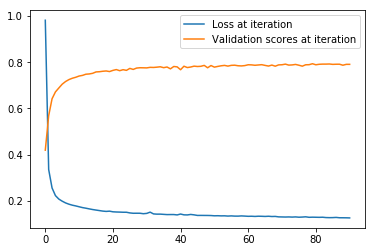

In [206]:
import matplotlib.pyplot as plt

# Visualize the loss curve and validation scores over iterations.
plt.plot(ann.loss_curve_, label='Loss at iteration')
plt.plot(ann.validation_scores_, label='Validation scores at iteration')
plt.legend(loc='best')
plt.show()

Finally, we can use our test data to check how our model performs on data that it has not been previously exposed to. Let's see how we did!

In [207]:
ann.score(scaled_test_data, test_labels)

0.8134489126715619

81.3% accuracy! Not bad, but it could definitely be better.

### Backpropagation

The heart of neural networks is [backpropagation algorithms](https://en.wikipedia.org/wiki/Backpropagation), which are an efficient way to 

In effect, an ANN is trained by:
1. Setting all weights and biases randomly.
2. For each row in the test data:
    1. Set the input units to the input features.
    2. Use unit weights and biases, passing through the activation function, to calculate the output value of each unit -- right through to the output units.
    3. Use a loss function to Compare the output units with the expected output
    4. Use a backpropagation algorithm to update all the weights and biases to reduce the loss.
    
Google has a [nice visual explanation](https://google-developers.appspot.com/machine-learning/crash-course/backprop-scroll/) of backpropagation. [More detailed explanations](http://neuralnetworksanddeeplearning.com/chap2.html) are also available.
    
### When backpropagation goes wrong

* Vanishing gradients: when weights for lower levels (closer to the input) become very small, gradients become very small too, making it hard or impossible to train these layers. The ReLU activation function can help prevent vanishing gradients.

* Exploding gradients: when weights become very large, the gradients for lower layers can become very large, making it hard for these gradients to converge. Batch normalization can help prevent exploding gradients, as can lowering the learning rate.

* Dead ReLU units: once the weighted sum for a ReLU activation function falls below 0, the ReLU unit can get stuck -- without an output, it doesn't contribute to the network output, and gradients can't flow through it in backpropagation. Lowering the learning rate can help keep ReLU units from dying.

* Dropout regularization: in this form of regularization, a proportion of unit activations are randomly dropped out. This prevents overfitting and so helps create a better model.

In [76]:

import numpy as np
import pandas

wine_quality_reds = pandas.read_csv("../nb-datasets/winequality/winequality-red.csv", delimiter=';')
print("Wine quality reds shape: ", wine_quality_reds.shape)
wine_quality_reds.head()

Wine quality reds shape:  (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


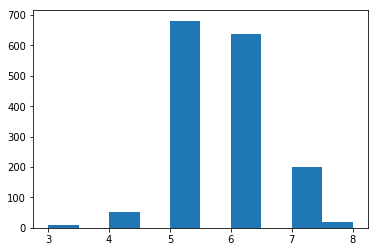

In [124]:
import matplotlib.pyplot as plt
plt.hist(wine_quality_reds['quality'])
plt.show()

In [80]:
from sklearn.utils import shuffle
wine_quality_reds_shuffled = shuffle(wine_quality_reds)

print("First entry from wine_quality_reds: ", wine_quality_reds_shuffled.iloc[1,])
print("Shape of wine_quality_reds: ", wine_quality_reds_shuffled.shape)

First entry from wine_quality_reds:  fixed acidity           10.2000
volatile acidity         0.6700
citric acid              0.3900
residual sugar           1.9000
chlorides                0.0540
free sulfur dioxide      6.0000
total sulfur dioxide    17.0000
density                  0.9976
pH                       3.1700
sulphates                0.4700
alcohol                 10.0000
quality                  5.0000
Name: 485, dtype: float64
Shape of wine_quality_reds:  (1599, 12)


In [117]:
test_data = wine_quality_reds_shuffled.iloc[0:200,:-1]
test_labels = wine_quality_reds_shuffled.iloc[0:200,-1]
print(test_data.head())
print(test_labels[0:10])
print("Test data shape: ", test_data.shape)
print("Test labels shape: ", test_labels.shape)

train_data = wine_quality_reds_shuffled.iloc[200:,:-1]
train_labels = wine_quality_reds_shuffled.iloc[200:,-1]
print(train_data.head())
print(train_labels[0:10])
print("Train data shape: ", train_data.shape)
print("Train labels shape: ", train_labels.shape)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
1549            7.4              0.36         0.30             1.8      0.074   
485            10.2              0.67         0.39             1.9      0.054   
845             6.4              0.64         0.21             1.8      0.081   
1512            6.4              0.79         0.04             2.2      0.061   
1419            7.7              0.64         0.21             2.2      0.077   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
1549                 17.0                  24.0  0.99419  3.24       0.70   
485                   6.0                  17.0  0.99760  3.17       0.47   
845                  14.0                  31.0  0.99689  3.59       0.66   
1512                 11.0                  17.0  0.99588  3.53       0.65   
1419                 32.0                 133.0  0.99560  3.27       0.45   

      alcohol  
1549     11.4  
485      10.0  
84

In [118]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Figure out how to scale all the input features in the training dataset.
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
print(scaled_train_data[1:10])

# Also tranform our validation and testing data in the same way.
scaled_test_data = scaler.transform(test_data)
print(scaled_test_data[1:10])

[[ 0.84657716  2.55734744  0.23421329 -0.17067894 -0.19392684  1.86030854
   3.26753038  0.66853316 -0.39177645 -1.05103794 -0.95561073]
 [ 0.04327014 -0.86079367  1.30885832 -0.53533965  6.93053211 -0.66142224
  -0.63453962  0.61508412 -1.62783695  2.37193299 -1.23633434]
 [ 0.44492365  0.76422424 -0.63573746  0.48571035  0.21014695 -0.66142224
   0.3874311   1.60923612 -0.196609   -0.6969375  -0.76846165]
 [-0.24362523  0.25990834  0.18303971 -0.38947537 -0.1726598  -0.56443259
   1.00680729  0.01111006 -0.13155318  0.1883136  -0.86203619]
 [-0.9321741  -0.35647776 -0.1751753  -0.6082718  -0.21519388  0.21148457
  -0.38678914 -1.04183587  0.51900498 -0.34283706  0.16728371]
 [ 0.10064921 -0.86079367 -0.37986959  0.19398178  0.06127766  0.21148457
   0.35646229  0.66853316  0.1937259   0.24733034 -0.76846165]
 [-0.35838337  0.59611894 -0.99395247 -0.46240751 -0.23646092 -0.07948437
  -0.60357081 -0.02630426  0.06361426 -0.6969375  -0.86203619]
 [ 1.19085159 -1.02889897  1.56472619  0.

In [119]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(
    solver='adam',  # The solver to use
    alpha=1e-5,     # The L2 regularization rate: higher values increase cost for larger weights
    hidden_layer_sizes=(100,20),
                    # 
                    # Note that we don't need to specify input and output neuron numbers: MLPClassifier
                    # determines this based on the shape of the features and labels being fitted.
    batch_size='auto',
    verbose=True,
    early_stopping=True
)
clf.fit(scaled_train_data, train_labels)

Iteration 1, loss = 15.89807853
Validation score: -41.269136
Iteration 2, loss = 13.52455430
Validation score: -35.133402
Iteration 3, loss = 11.45937344
Validation score: -29.558688
Iteration 4, loss = 9.54815171
Validation score: -24.182068
Iteration 5, loss = 7.72429186
Validation score: -18.988949
Iteration 6, loss = 5.99571242
Validation score: -14.146144
Iteration 7, loss = 4.41744734
Validation score: -10.020771
Iteration 8, loss = 3.14311831
Validation score: -6.913596
Iteration 9, loss = 2.26422656
Validation score: -4.960597
Iteration 10, loss = 1.73319844
Validation score: -3.953273
Iteration 11, loss = 1.48036928
Validation score: -3.450722
Iteration 12, loss = 1.35163622
Validation score: -3.114612
Iteration 13, loss = 1.25916743
Validation score: -2.824202
Iteration 14, loss = 1.16664660
Validation score: -2.579440
Iteration 15, loss = 1.09304121
Validation score: -2.344964
Iteration 16, loss = 1.03457022
Validation score: -2.175792
Iteration 17, loss = 0.98821672
Validat

Iteration 144, loss = 0.15499209
Validation score: 0.411853
Iteration 145, loss = 0.15489267
Validation score: 0.408450
Iteration 146, loss = 0.15407375
Validation score: 0.418725
Iteration 147, loss = 0.15319099
Validation score: 0.418061
Iteration 148, loss = 0.15255840
Validation score: 0.416452
Iteration 149, loss = 0.15244304
Validation score: 0.409116
Iteration 150, loss = 0.15176418
Validation score: 0.420624
Iteration 151, loss = 0.15147030
Validation score: 0.422123
Iteration 152, loss = 0.15124589
Validation score: 0.429154
Iteration 153, loss = 0.15141312
Validation score: 0.429950
Iteration 154, loss = 0.15273070
Validation score: 0.424171
Iteration 155, loss = 0.15075355
Validation score: 0.422304
Iteration 156, loss = 0.15043432
Validation score: 0.422663
Iteration 157, loss = 0.15006163
Validation score: 0.415816
Iteration 158, loss = 0.15080315
Validation score: 0.435217
Iteration 159, loss = 0.14838936
Validation score: 0.426929
Iteration 160, loss = 0.14890713
Validat

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [120]:
clf.score(scaled_test_data, test_labels)

0.37007431621793896

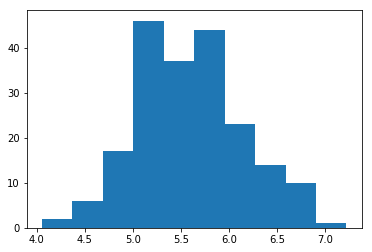

In [125]:
plt.hist(clf.predict(scaled_test_data))
plt.show()

## ANN for classification: what sort of forest is this?
Let's jump in with a dataset called [Covertype](https://archive.ics.uci.edu/ml/datasets/Covertype), where we try to predict forest cover type based on a number of features of a 30x30m area of forest as follows:

| Column | Feature | Units | Description | How measured |
|---|--------|-------|-------------|--------------|
| 1 | Aspect | degrees azimuth | Aspect in degrees azimuth | Quantitative |
| 2 | Slope | degrees | Slope in degrees | Quantitative |
| 3 | Horizontal_Distance_To_Hydrology | meters | Horz Dist to nearest surface water features | Quantitative |
| 4 | Vertical_Distance_To_Hydrology | meters | Vert Dist to nearest surface water features | Quantitative |
| 5 | Horizontal_Distance_To_Roadways | meters | Horz Dist to nearest roadway | Quantitative |
| 6 | Hillshade_9am | 0 to 255 index | Hillshade index at 9am, summer solstice | Quantitative |
| 7 | Hillshade_Noon | 0 to 255 index | Hillshade index at noon, summer soltice | Quantitative |
| 8 | Hillshade_3pm | 0 to 255 index | Hillshade index at 3pm, summer solstice | Quantitative |
| 9 | Horizontal_Distance_To_Fire_Points | meters | Horz Dist to nearest wildfire ignition points | Quantitative |
| 10-14 | Wilderness_Area | 4 binary columns with 0 (absence) or 1 (presence) | Which wilderness area this plot is in | Qualitative |
| 14-54 | Soil_Type | 40 binary columns with 0 (absence) or 1 (presence) | Soil Type designation | Qualitative |

Using this information, we are trying to classify each 30x30m plot as one of seven forest types.

This dataset is built into Scikit, so we can use it to download and load the dataset for use.

In [2]:
from sklearn import datasets
help(datasets.fetch_covtype)

Help on function fetch_covtype in module sklearn.datasets.covtype:

fetch_covtype(data_home=None, download_if_missing=True, random_state=None, shuffle=False, return_X_y=False)
    Load the covertype dataset (classification).
    
    Download it if necessary.
    
    =================   ============
    Classes                        7
    Samples total             581012
    Dimensionality                54
    Features                     int
    =================   ============
    
    Read more in the :ref:`User Guide <covtype_dataset>`.
    
    Parameters
    ----------
    data_home : string, optional
        Specify another download and cache folder for the datasets. By default
        all scikit-learn data is stored in '~/scikit_learn_data' subfolders.
    
    download_if_missing : boolean, default=True
        If False, raise a IOError if the data is not locally available
        instead of trying to download the data from the source site.
    
    random_state : int, Rand

So we don't need to provide any arguments, but it warns us that it may need to download this dataset. It also describes the the returned dataset object will have the following properties:
- .data: a numpy array with the features.
- .target: a numpy array with the target labels. Note that each plot is classified into only one of these values.
- .DESCR: describe this forest covertype.

In [3]:
covtype = datasets.fetch_covtype(shuffle=True)
print("Data: ", covtype.data)
print("Data shape: ", covtype.data.shape) # Describe the size of this array

Data:  [[2670.  108.   12. ...    0.    0.    0.]
 [3204.  253.   12. ...    0.    0.    0.]
 [3039.  320.   16. ...    0.    0.    0.]
 ...
 [2806.   43.    9. ...    0.    0.    0.]
 [3066.  283.    6. ...    0.    0.    0.]
 [3225.  208.   28. ...    0.    0.    0.]]
Data shape:  (581012, 54)


In [19]:
print("Target: ", covtype.target)
print("Target shape: ", covtype.target.shape)

Target:  [3 1 1 ... 1 2 1]
Target shape:  (581012,)


In [20]:
print("Description: ", covtype.DESCR)

Description:  .. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30×30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <http://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

    =================   ============
    Classes                        7
    Samples total             581012
    Dimensionality                54
    Features                     int
    =================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like object
with the feature matrix in the ``data`` member
and the target values in ``target``.
The data

## Training data for training, testing data for testing, and validation data for validation.


In [21]:
# Out of 581,012 data entries, let's hold back:
# - 250,000 records as our test dataset
# - remaining records as our training dataset

test_data = covtype.data[0:250_000]
test_labels = covtype.target[0:250_000]

train_data = covtype.data[250_000:]
train_labels = covtype.target[250_000:]

print("Validation data shape: ", validation_data.shape)
print("Validation labels shape: ", validation_labels.shape)

print("Test data shape: ", test_data.shape)
print("Test labels shape: ", test_labels.shape)

print("Training data shape: ", train_data.shape)
print("Training labels shape: ", train_labels.shape)

Validation data shape:  (50000, 54)
Validation labels shape:  (50000,)
Test data shape:  (250000, 54)
Test labels shape:  (250000,)
Training data shape:  (281012, 54)
Training labels shape:  (281012,)


Our data is ready for processing. But remember that we have a variety of different input types: binary (0, 1), continuous in small ranges (0-255) and in large ranges (elevations). Before we process this data, we should normalize them into a standard range.

In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# scaler = MinMaxScaler()
scaler = StandardScaler()

# Figure out how to scale all the input features in the training dataset.
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
print(scaled_train_data[0])

# Also tranform our validation and testing data in the same way.
scaled_test_data = scaler.transform(test_data)
print(scaled_test_data[0])

[ 1.60736862e+00  1.26976625e+00  2.52424211e+00 -1.32789752e-01
 -8.46317415e-01  5.45818884e-01 -3.70587203e+00 -7.77004916e-01
  2.17874024e+00 -8.66734546e-02  1.10618082e+00 -2.32878738e-01
 -8.77654257e-01 -2.60891433e-01 -7.33790197e-02 -1.13756645e-01
 -9.06824489e-02 -1.47164828e-01 -5.28596572e-02 -1.06780531e-01
 -1.36044010e-02 -1.83896215e-02 -4.50039975e-02 -2.44733925e-01
 -1.47354014e-01 -2.33743604e-01 -1.75417877e-01 -3.15815220e-02
 -1.88641977e-03 -7.04798023e-02 -7.70864687e-02 -5.74366014e-02
 -8.33979573e-02 -1.25961739e-01 -3.82249167e-02 -2.47644451e-01
 -3.31516804e-01 -1.94359553e-01 -2.76708817e-02 -6.70314648e-02
 -4.31396443e-02 -4.12782423e-02 -4.99658577e-01 -2.33963654e-01
 -2.14121142e-01 -3.14156848e-01 -2.90124367e-01 -5.24519154e-02
 -5.69983904e-02 -1.57848582e-02 -2.34162292e-02 -1.65615860e-01
  6.39371431e+00 -1.23519671e-01]
[ 1.13253983e+00 -2.93736903e-01  2.54632485e-01 -5.64809237e-01
 -1.70261524e+00 -1.11786676e+00  1.22878378e+00  1.8417

## Classifying among multiple categories

Having multiple output units usually would result in each unit being considered independently, allowing you to assign multiple labels for a particular input (for instance, a single image might be classified as containing both a cloud as well as a bird). However, we use scikit-learn's [MLPClassifier](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification), which automatically uses *softmax* to treat labels as exclusive to each other.

### The power of softmax

As based on [](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax)

TODO

In [26]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(
    solver='adam',  # The solver to use
    alpha=1e-5,     # The L2 regularization rate: higher values increase cost for larger weights
    hidden_layer_sizes=(100),
                    # 
                    # Note that we don't need to specify input and output neuron numbers: MLPClassifier
                    # determines this based on the shape of the features and labels being fitted.
    batch_size='auto',
    verbose=True,
    early_stopping=True
)
clf.fit(scaled_train_data, train_labels)

Iteration 1, loss = 0.66653904
Validation score: 0.749413
Iteration 2, loss = 0.56445348
Validation score: 0.765035
Iteration 3, loss = 0.53419656
Validation score: 0.777169
Iteration 4, loss = 0.51499368
Validation score: 0.780941
Iteration 5, loss = 0.50032446
Validation score: 0.787311
Iteration 6, loss = 0.48875770
Validation score: 0.794285
Iteration 7, loss = 0.47942608
Validation score: 0.797452
Iteration 8, loss = 0.47112352
Validation score: 0.795815
Iteration 9, loss = 0.46449897
Validation score: 0.805388
Iteration 10, loss = 0.45811287
Validation score: 0.808590
Iteration 11, loss = 0.45244680
Validation score: 0.811330
Iteration 12, loss = 0.44708846
Validation score: 0.809978
Iteration 13, loss = 0.44114382
Validation score: 0.816526
Iteration 14, loss = 0.43669484
Validation score: 0.812825
Iteration 15, loss = 0.43251937
Validation score: 0.819088
Iteration 16, loss = 0.42858463
Validation score: 0.816170
Iteration 17, loss = 0.42432445
Validation score: 0.821543
Iterat

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=100, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [25]:
clf.score(scaled_test_data, test_labels)

0.87952